Modifications:

1. Turn different models into another file, and VWAP should import the models to read models.
2. Rewrite VWAP LSTM factor

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
import keras
import pickle

Using TensorFlow backend.


In [2]:
import os

data_dir="./data/"
ticker="TSLA"

date_pool=pd.date_range("1/1/2019","1/31/2019",freq="B").strftime("%Y%m%d")
date_pool=[d for d in date_pool if os.path.exists(data_dir+"trades_{}_{}.csv".format(d,ticker))]

train_days=10
train_date_list=date_pool[:train_days]
test_date_list=date_pool[train_days+1:]
time_steps = 50

nforward=10

In [3]:
class Pipeline():
    def __init__(self):
        self.x = None
        self.y = None
        self.scaler = None
    def load_data(self, ticker, date):
        df = pd.read_csv(data_dir+'trades_{}_{}.csv'.format(date, ticker),index_col=[0],parse_dates=[0])

        # Feature Engineering
        df["direction"]=(df["trade_px"]-df["trade_px"].shift(1)).apply(np.sign)
        df["pct_change"]=df["trade_px"].pct_change()

        mysign=lambda x: 0 if abs(x)<1e-5 else (1 if x>0 else -1)
        df["label"]=(df["trade_px"].rolling(nforward).mean().shift(-nforward)-df["trade_px"]).apply(mysign)
        # df["label"]=(df["trade_px"].shift(-1)-df["trade_px"]).apply(np.sign) # last version

        df.fillna(method="ffill",inplace=True)
        df.dropna(axis=0,inplace=True)
        # print(df.head(10),df.shape)
        # print("NaN number: ",df.isna().sum().sum())

        return df[["trade_px","trade_size","pct_change","direction","label"]].values

    def create_dataset(self, ticker=ticker, dates=train_date_list, time_steps = time_steps, input_scaler=None):  
        for i,d in enumerate(dates):
            datanew = self.load_data(ticker,d)
            if i==0:
                data=datanew
            else:
                data=np.vstack((data, datanew))

        label=data[:,-1]
        data=data[:,:-1]

        if input_scaler is None:
            scaler=StandardScaler()
            data=scaler.fit_transform(data)
        else:
            data=input_scaler.transform(data)
            scaler=input_scaler

        x = [data[0 : time_steps]]
        y = [label[time_steps-1]]
        N=len(data)//time_steps

        print(N)
        for i in range(1, N):
            t = data[i*time_steps: (i + 1)*time_steps]
            x = np.vstack((x, [t]))
            y.append(label[(i + 1)*time_steps-1])

        y=pd.get_dummies(y)
        #print(y)

        return x,y.values,scaler

    def loss_plot(self, history, plot_name = 'Loss'): # type(history) is dict
        loss = np.asarray(history['loss'])
        val_loss = np.asarray(history['val_loss'])

        plt.style.use('seaborn')
        plt.figure(figsize = (20,6), dpi=dpi)
        plt.grid(True)
        plt.plot(loss, color = 'darkgrey')
        plt.plot(val_loss, color = 'tan')
        plt.legend(['loss', 'val_loss'])
        # plt.savefig('{}_{}_{}_{}_{}.png'.format(ticker, plot_name, str(n_epochs), str(time_steps), str(batch_size)))
    
    
    def training_data_transform(self, ticker):
        # Load train data
        x, y, scaler = self.create_dataset(ticker)
        self.x, self.y, self.scaler = x, y, scaler
        print("Finished loading data.")

        with open("model/scaler_{}_{}.p".format(train_date_list[0],train_date_list[-1]),"wb") as f:
            pickle.dump(scaler,f)

    def model_training_testing(self, ticker, model, plot = False):
        # Model Training pipeline
        model_functionalities = Model_Functionalities(model)
        
        x, y, scaler = self.x, self.y, self.scaler
        
        if x is None:
            print("None Training data processed")
            return
        
        # Build model, in-sample train test
        train_history = model_functionalities.train_test(x, y, plot)  
        if model_functionalities.model.model_name == "LSTM":
            if plot == True:
                self.loss_plot(train_history.history)

        with open("model/" + model.model_name + "_{}_{}.p".format(train_date_list[0],train_date_list[-1]),"wb") as f:
            pickle.dump(model,f)

        # Out-of-sample test
        for test_date in test_date_list:
            # create test dateset
            x_test, y_test, _ = self.create_dataset(ticker=ticker, dates=[test_date], time_steps = time_steps, input_scaler=scaler)
            x_test, y_test = model_functionalities.model.reshape_dataset(x_test, y_test)

            # use precious trained model to test
            y_test_pred = model_functionalities.predict(x_test)
            if model_functionalities.model.model_name == "LSTM":
                if plot == True:
                    model_functionalities.view_accuracy(y_test_pred.argmax(axis=1), y_test.argmax(axis=1))
            if y_test.shape[1] != 1:
                accuracy = np.mean(y_test_pred.argmax(axis=1)==y_test.argmax(axis=1))
            else:
                accuracy = np.mean(y_test_pred==y_test)
            print(test_date+" accuracy: ", accuracy)
        return model_functionalities.model

In [4]:
pipeline = Pipeline()
pipeline.training_data_transform(ticker)

15154
Finished loading data.


In [5]:
class Model_Functionalities():
    def __init__(self, model):
        self.model = model
    def train_test(self, x, y, plot = False):
        
        size = len(x)
        if size!=len(y):
            return None
        x = x[: batch_size * (size // batch_size)]
        y = y[: batch_size * (size // batch_size)]
        
        x, y = self.model.reshape_dataset(x, y)

        x_train, x_validation, y_train, y_validation= train_test_split(x, y, test_size = 0.1, shuffle = True)
        print('train', x_train.shape, y_train.shape)
        print('validation', x_validation.shape, y_validation.shape)
        
        
        if self.model.model_name == "LSTM" or  self.model.model_name == "CNN":
            early_stopping = EarlyStopping(monitor='val_loss', patience=stop_patience, mode="min", verbose=2, restore_best_weights=True)
            history = self.model.fit(x_train, y_train, batch_size = batch_size, epochs = n_epochs,
                                     validation_data=(x_validation, y_validation),callbacks=[early_stopping])
        else:
            self.model.fit(x_train, y_train)
        
        self.y_pred = self.model.predict(x_validation)
        self.y_validation_true = y_validation
        
        if plot == True:
            if y.shape[1] != 1:
                self.train_plot = self.view_accuracy(self.predict(x_train).argmax(axis=1), y_train.argmax(axis=1), 'Train')
                self.validation_plot = self.view_accuracy(self.predict(x_validation).argmax(axis=1), y_validation.argmax(axis=1), 'Validation')
            else:
                self.train_plot = self.view_accuracy(self.predict(x_train), y_train, 'Train')
                self.validation_plot = self.view_accuracy(self.predict(x_validation), y_validation, 'Validation')
        if self.model.model_name == "LSTM":
            return history

    def predict(self, x_validation):
        pred = self.model.predict(x_validation)
        return pred
    
    def view_accuracy(self, y_pred = None, y_true = None, plot_name = 'Test', num=100):
        if y_pred is None:
            y_pred = self.y_pred.argmax(axis=1)
            y_true = self.y_validation_true.argmax(axis=1)
        
        plt.style.use('seaborn')
        plt.figure(figsize = (20,6), dpi=dpi)
        plt.grid(True)
        plt.plot(y_pred[:num], color = 'lightcoral')
        plt.plot(y_true[:num], color = 'cornflowerblue', linewidth = 1)
        plt.title('{}_{}'.format(ticker, plot_name))
        plt.legend(['predict', 'true'])

# Using LSTM to predict next up and down
## v2: Predict up and downs of the average of $\mathbf{nforward}=10$ following prices

1. Too slow to predict (next trade may happen in millisecond)
2. Only classification of up, down and same. No quantitative prediction (can be improved to predict quantity of price movement)

In [13]:
hidden_dim = 30
n_epochs = 100
batch_size = 128
activation = "tanh"
loss = 'categorical_crossentropy'
stop_patience=20

dpi=200


class LSTM_Model():
    def __init__(self):
        self.model = Sequential()
        self.model_name = "LSTM"
        return 
    
    def build(self,  time_steps = time_steps, data_dim = 1, output_dim = 3):
        # expected input batch shape: (batch_size, timesteps, data_dim)
        # the sample of index i in batch k is the follow-up for the sample i in batch k-1.
        self.model.add(LSTM(hidden_dim, activation=activation, return_sequences=True, input_shape=(time_steps, data_dim)))
        #self.model.add(LSTM(hidden_dim, activation=activation, return_sequences=True))
        self.model.add(LSTM(hidden_dim, activation=activation))
        self.model.add(Dense(output_dim, activation = 'softmax'))
        
        opt=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        self.model.compile(loss = loss, optimizer=opt, metrics=['accuracy']) 
        return self.model
    
    def fit(self, x_train, y_train, batch_size, epochs, validation_data, callbacks):
        return self.model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = validation_data, callbacks = callbacks)
    
    def predict(self, x):
        return self.model.predict(x)
    
    def reshape_dataset(self, x, y):
        if x is not None:
            if len(x.shape) == 2:
                x = x.reshape(x.shape[0], x.shape[1], 1)
        if len(y.shape) == 1:
            y = y.reshape(y.shape[0],1)
        return x, y 



#         if plot_name == 'Test':
#             plt.savefig('{}_{}_{}_{}.png'.format(ticker, plot_name, str(time_steps), str(batch_size)))
#         else:
#             plt.savefig('{}_{}_{}_{}.png'.format(ticker, plot_name, str(time_steps), str(batch_size)))


In [14]:
lstm_model = LSTM_Model()
lstm_model.build(time_steps = time_steps, data_dim = pipeline.x.shape[-1], output_dim = pipeline.y.shape[-1])
pipeline.model_training_testing(ticker, lstm_model)

train (13593, 50, 4) (13593, 3)
validation (1511, 50, 4) (1511, 3)
Train on 13593 samples, validate on 1511 samples
Epoch 1/100
13593/13593 [==============================] - 31s 2ms/step - loss: 0.8631 - accuracy: 0.5072 - val_loss: 0.7998 - val_accuracy: 0.5725
Epoch 2/100
13593/13593 [==============================] - 29s 2ms/step - loss: 0.8071 - accuracy: 0.5597 - val_loss: 0.7609 - val_accuracy: 0.6036
Epoch 3/100
13593/13593 [==============================] - 30s 2ms/step - loss: 0.7721 - accuracy: 0.5768 - val_loss: 0.7366 - val_accuracy: 0.6003
Epoch 4/100
13593/13593 [==============================] - 30s 2ms/step - loss: 0.7567 - accuracy: 0.5815 - val_loss: 0.7355 - val_accuracy: 0.5857
Epoch 5/100
13593/13593 [==============================] - 29s 2ms/step - loss: 0.7512 - accuracy: 0.5844 - val_loss: 0.7296 - val_accuracy: 0.6016
Epoch 6/100
13593/13593 [==============================] - 30s 2ms/step - loss: 0.7468 - accuracy: 0.5906 - val_loss: 0.7330 - val_accuracy: 0.5

In [15]:
print(pipeline.x.shape, pipeline.y.shape)

(15154, 50, 4) (15154, 3)


# CNN

In [16]:
from keras.layers import Dense, Conv2D, Flatten, Dropout
from keras import regularizers

In [18]:
cnn_model = CNN_Model()
cnn_model.build(time_steps = time_steps, data_dim = pipeline.x.shape[-1], output_dim = pipeline.y.shape[-1])
pipeline.model_training_testing(ticker, cnn_model)

train (13593, 50, 4, 1) (13593, 3)
validation (1511, 50, 4, 1) (1511, 3)
Train on 13593 samples, validate on 1511 samples
Epoch 1/100
13593/13593 [==============================] - 4s 266us/step - loss: 0.8572 - accuracy: 0.4842 - val_loss: 0.8251 - val_accuracy: 0.4752
Epoch 2/100
13593/13593 [==============================] - 3s 193us/step - loss: 0.8065 - accuracy: 0.5347 - val_loss: 0.7926 - val_accuracy: 0.5473
Epoch 3/100
13593/13593 [==============================] - 3s 200us/step - loss: 0.7744 - accuracy: 0.5775 - val_loss: 0.7802 - val_accuracy: 0.5619
Epoch 4/100
13593/13593 [==============================] - 3s 210us/step - loss: 0.7617 - accuracy: 0.5893 - val_loss: 0.7772 - val_accuracy: 0.5705
Epoch 5/100
13593/13593 [==============================] - 3s 215us/step - loss: 0.7542 - accuracy: 0.5910 - val_loss: 0.7735 - val_accuracy: 0.5625
Epoch 6/100
13593/13593 [==============================] - 3s 215us/step - loss: 0.7499 - accuracy: 0.5927 - val_loss: 0.7728 - val_a

# Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

In [30]:
class RandomForest():
    def __init__(self,max_depth=36, n_estimators=100, max_features=0.2, criterion = 'gini'):
        self.model = RandomForestClassifier(n_estimators=n_estimators, criterion = criterion, max_depth=max_depth,max_features=max_features)
        self.model_name = "Random_Forest"
    def fit(self,X,Y):
        return self.model.fit(X,Y)
    def predict(self,X):
        return self.model.predict(X)
    def reshape_dataset(self, x, y):
        if x is not None:
            if len(x.shape) == 3:
                x = x.reshape(x.shape[0], x.shape[1]*x.shape[2])
        if len(y.shape) == 1:
            y = y.reshape(y.shape[0],1)
        return x, y 

In [31]:
random_forest_model = RandomForest()
pipeline.model_training_testing(ticker, random_forest_model)

train (13593, 200) (13593, 3)
validation (1511, 200) (1511, 3)
808
20190117 accuracy:  0.5297029702970297
5342
20190118 accuracy:  0.5943466866342194
2570
20190122 accuracy:  0.5501945525291829
2944
20190123 accuracy:  0.5315896739130435
1759
20190124 accuracy:  0.5105173393973849
1610
20190125 accuracy:  0.5186335403726708
1428
20190128 accuracy:  0.5329131652661064
1034
20190129 accuracy:  0.5261121856866537
2164
20190130 accuracy:  0.5600739371534196
2679
20190131 accuracy:  0.555431131019037


# GradientBoost

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

In [23]:
class GradientBoost():
    def __init__(self):
        self.model = GradientBoostingClassifier(n_estimators=500,max_depth=50,learning_rate=0.05)
        self.model_name = "GradientBoost"
    def fit(self,X,Y):
        return self.model.fit(X,Y)
    def predict(self,X):
        return self.model.predict(X)
    def reshape_dataset(self, x, y):
        if x is not None:
            if len(x.shape) == 3:
                x = x.reshape(x.shape[0], x.shape[1]*x.shape[2])
        if len(y.shape) != 1:
            y = np.where(y==1)[1]
            y = y.reshape(y.shape[0],1)
        return x, y 

In [24]:
gradient_boost_model=GradientBoost()
pipeline.model_training_testing(ticker, gradient_boost_model)

train (13593, 200) (13593, 1)
validation (1511, 200) (1511, 1)


/Users/xunyingluo/anaconda3/envs/py36/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


808
20190117 accuracy:  0.4730050975394569
5342
20190118 accuracy:  0.44296824988110156
2570
20190122 accuracy:  0.4501047707005405
2944
20190123 accuracy:  0.44406087547258977
1759
20190124 accuracy:  0.4522409077202568
1610
20190125 accuracy:  0.4553180818641256
1428
20190128 accuracy:  0.4545479956688558
1034
20190129 accuracy:  0.460467883077867
2164
20190130 accuracy:  0.46853101157915955
2679
20190131 accuracy:  0.46968284004508265


# XGBOOST

In [25]:
from xgboost import XGBClassifier

In [26]:
class XGBoost():
    def __init__(self):
        self.model =XGBClassifier(n_estimators=100, max_depth=50,learning_rate=0.1,reg_lambda=0.1, verbose=True)
        self.model_name = "XGBoost"
    def fit(self,X,Y):
        return self.model.fit(X,Y)
    def predict(self,X):
        return self.model.predict(X)
    def reshape_dataset(self, x, y):
        if x is not None:
            if len(x.shape) == 3:
                x = x.reshape(x.shape[0], x.shape[1]*x.shape[2])
        if len(y.shape) != 1:
            y = np.where(y==1)[1]
            y = y.reshape(y.shape[0],1)
        return x, y 

In [27]:
xgboost_model=XGBoost()
pipeline.model_training_testing(ticker, xgboost_model)

train (13593, 200) (13593, 1)
validation (1511, 200) (1511, 1)


/Users/xunyingluo/anaconda3/envs/py36/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xunyingluo/anaconda3/envs/py36/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


808
20190117 accuracy:  0.4788271370453877
5342
20190118 accuracy:  0.44020975742198787
2570
20190122 accuracy:  0.4595206589047525
2944
20190123 accuracy:  0.45331733573812616
1759
20190124 accuracy:  0.46548038011933107
1610
20190125 accuracy:  0.4832969407044481
1428
20190128 accuracy:  0.47455894122354825
1034
20190129 accuracy:  0.48898663992906555
2164
20190130 accuracy:  0.4749074077237675
2679
20190131 accuracy:  0.4738826209854451


#  Tick Factor

In [28]:
# TICK FACTOR
# only update if it's a trade
# if message_type == 't':
#     # calc the tick
#     this_tick = np.sign(last_price - prev_price)
#     if this_tick == 0:
#         this_tick = prev_tick

#     # now calc the tick
#     if tick_factor == 0:
#         tick_factor = this_tick
#     else:
#         tick_factor = (tick_ema_alpha * this_tick) + (1 - tick_ema_alpha) * tick_factor

#         # store the last tick
#     prev_tick = this_tick

for test_date in test_date_list:
    df = pd.read_csv(data_dir+'trades_{}_{}.csv'.format(test_date, ticker),index_col=[0],parse_dates=[0])
    
    df["tick_test"]=(df["trade_px"]-df["trade_px"].shift(1)).apply(lambda x: 1 if x>0. else (-1. if x<0 else np.nan))
    df.fillna(method="ffill",inplace=True)
    
    df["tick_factor"]=df["tick_test"].ewm(span=20).mean()
    df.dropna(axis=0,inplace=True)
    
    mysign = lambda x: 0 if abs(x)<1e-5 else (1 if x>0 else -1)
    df["predict"]=df["tick_factor"].apply(mysign)
    df["real_movement"]=(df["trade_px"].rolling(nforward).mean().shift(-nforward)-df["trade_px"]).apply(mysign)
    
    df.dropna(axis=0,inplace=True)
    acc=np.mean(df["predict"]==df["real_movement"])
    print("Accuracy of {}".format(test_date),acc)


Accuracy of 20190117 0.4707643580036127
Accuracy of 20190118 0.43095347731518396
Accuracy of 20190122 0.4555151005928208
Accuracy of 20190123 0.45868338302510847
Accuracy of 20190124 0.4674517203359969
Accuracy of 20190125 0.463677230280151
Accuracy of 20190128 0.48354217710885544
Accuracy of 20190129 0.45997873779839565
Accuracy of 20190130 0.45219857893910137
Accuracy of 20190131 0.4725264061508603


Average time interval between 10 trades is 0 days 00:00:02.094658


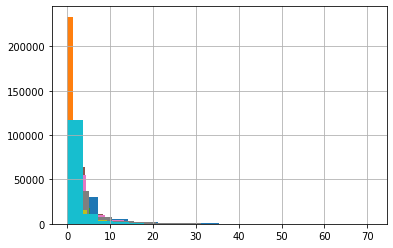

In [29]:
sum=pd.Timedelta(0)
count=0
for test_date in test_date_list:
    df = pd.read_csv(data_dir+'trades_{}_{}.csv'.format(test_date, ticker),index_col=[0],parse_dates=[0])
    timestamp=pd.DataFrame({"trade_time":df.index})
    dt=timestamp["trade_time"].shift(-nforward)-timestamp["trade_time"]
    dt.dropna(axis=0,inplace=True)
    dt.apply(lambda x:x.seconds).hist()
    sum+=dt.sum()
    count+=dt.shape[0]
print("Average time interval between {} trades is".format(nforward),sum/count)